In [24]:
import cv2
import pytesseract
import numpy as np
import math
from pytesseract import Output
import matplotlib.pyplot as plt

In [25]:
image = cv2.imread("manometer.jpg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [3]:
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=200)

In [4]:
# Повышение контраста
gray_eq = cv2.equalizeHist(gray)

# Гауссово размытие
blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)

# Поиск границ
edges = cv2.Canny(blurred, threshold1=50, threshold2=150)

# Найдём центр циферблата через HoughCircles
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                           param1=100, param2=30, minRadius=50, maxRadius=150)


In [5]:
def analyze_manometer(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_eq = cv2.equalizeHist(gray)
    blurred = cv2.GaussianBlur(gray_eq, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)

    # Поиск круга (циферблата)
    circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100,
                               param1=100, param2=30, minRadius=50, maxRadius=150)

    if circles is None:
        print("Циферблат не найден.")
        return

    circles = np.uint16(np.around(circles))
    x_center, y_center, radius = circles[0][0]
    cv2.circle(image, (x_center, y_center), radius, (0, 255, 0), 2)
    cv2.circle(image, (x_center, y_center), 2, (0, 0, 255), 3)

    # Поиск стрелки (прямая от центра)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50,
                            minLineLength=radius // 2, maxLineGap=20)
    best_line = None
    max_length = 0
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            dist_to_center1 = np.hypot(x1 - x_center, y1 - y_center)
            dist_to_center2 = np.hypot(x2 - x_center, y2 - y_center)
            if min(dist_to_center1, dist_to_center2) < radius * 0.2:
                length = np.hypot(x2 - x1, y2 - y1)
                if length > max_length:
                    max_length = length
                    best_line = (x1, y1, x2, y2)

    if best_line:
        x1, y1, x2, y2 = best_line
        if np.hypot(x1 - x_center, y1 - y_center) > np.hypot(x2 - x_center, y2 - y_center):
            tip_x, tip_y = x1, y1
        else:
            tip_x, tip_y = x2, y2

        dx = tip_x - x_center
        dy = y_center - tip_y
        angle_deg = math.degrees(math.atan2(dy, dx)) % 360
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        print(f"Угол наклона стрелки: {angle_deg:.2f}°")
    else:
        print("Стрелка не найдена.")
        return

    # Показываем изображение с аннотациями
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.title("Анализ манометра")
    plt.show()
    return angle_deg, x_center, y_center, radius

Угол наклона стрелки: 225.00°


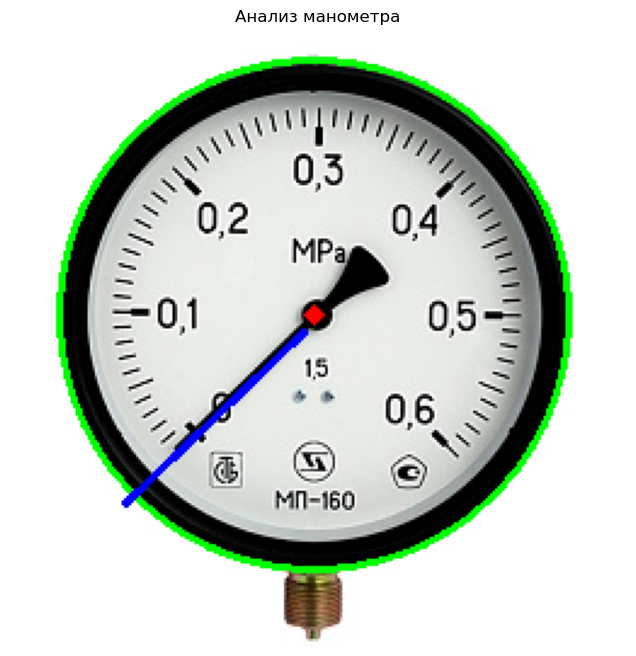

In [6]:
angle_deg, x_center, y_center, radius = analyze_manometer("manometer.jpg")